[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kevin7261/Geographic-Data-Science-with-Python/blob/main/Global_Spatial_Autocorrelation.ipynb)

# Global Spatial Autocorrelation

https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html

In [111]:
# @title 初始值設定

PROJECT_NAME = "15_台南市區_合併位置"
GEOJSON_NAME = "台南市區"

DENGUE_DAILY_GSHEET_PATH = "https://docs.google.com/spreadsheets/d/1vYyoq0Vf07kuWJU0Rg375jpHT9r9WzA2jiCPl3V3Oi4/edit?gid=2026372005#gid=2026372005"
GEOJSON_FILE_PATH = "https://drive.google.com/file/d/1iFFy5BXL_zL7bwYnqElDe-xrIeTcc3fd/view?usp=sharing"
WORKSHEET_NAME = PROJECT_NAME

In [112]:
# @title 下載台北思源黑體

# 下載台北思源黑體，並隱藏輸出
!wget -q -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 匯入必要的庫
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 新增字體
fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')

# 設定字體
mpl.rc('font', family='Taipei Sans TC Beta')


In [113]:
# @title 安裝套件

!pip install -q geopandas gdown
!pip install -q pysal splot contextily

---

# An empirical illustration


In [114]:
# @title 匯入函式庫

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

## 資料集

1. 2015年台南市登革熱病例 (xlsx)
1. 台南市最小統計區 (shp)

In [115]:
# @title 載入2015年台南市登革熱病例(gsheet)

# ✅ 匯入套件
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default
from gspread_dataframe import get_as_dataframe

SPREADSHEET_ID_GSHEET = DENGUE_DAILY_GSHEET_PATH.split("/d/")[1].split("/")[0]

# ✅ 認證授權
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# ✅ 開啟工作表
sh = gc.open_by_key(SPREADSHEET_ID_GSHEET)
worksheet = sh.worksheet(WORKSHEET_NAME)

# ✅ 將工作表轉為 DataFrame
ref = get_as_dataframe(worksheet)  # 可加入 index_col="name" 如欄位存在

ref.set_index("name", inplace=True)

# ✅ 預覽資料
ref.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3937 entries, A6737-0210-00 to A6423-0101-00
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   3937 non-null   float64
 1   longitude  3937 non-null   float64
 2   x          3937 non-null   float64
 3   y          3937 non-null   float64
 4   count      3937 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 184.5+ KB


In [116]:
# @title 下載geojson

import gdown

# ✅ 從 Google Drive 分享連結中提取檔案 ID
file_id = GEOJSON_FILE_PATH.split("/d/")[1].split("/")[0]

# ✅ 建立 direct download 連結
download_url = f"https://drive.google.com/uc?id={file_id}"

# ✅ 執行下載（保留原始檔名）
gdown.download(download_url, quiet=False)  # 不指定 output，就會用原檔名

# ✅ 驗證是否下載成功
import os
downloaded_files = os.listdir()
print("📂 當前目錄檔案：", downloaded_files)

Downloading...
From: https://drive.google.com/uc?id=1iFFy5BXL_zL7bwYnqElDe-xrIeTcc3fd
To: /content/台南市區.geojson
100%|██████████| 5.88M/5.88M [00:00<00:00, 36.7MB/s]

📂 當前目錄檔案： ['.config', '台南市區.geojson', 'TaipeiSansTCBeta-Regular.ttf', 'sample_data']


In [117]:
# @title 載入台南市最小統計區(geojson)

lads = geopandas.read_file(
    f"{GEOJSON_NAME}.geojson",
).set_index("CODEBASE")
lads.info()

#print(lads.crs) # EPSG:4979 Geodetic 3D coordinate system

lads.set_crs(epsg=3826, inplace=True, allow_override=True) # EPSG:3826 TWD97

#print(lads.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5146 entries, A6733-0874-00 to A6735-0854-00
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   U_ID       5146 non-null   int32   
 1   CODE1      5146 non-null   object  
 2   CODE2      5146 non-null   object  
 3   TOWN_ID    5146 non-null   object  
 4   TOWN       5146 non-null   object  
 5   COUNTY_ID  5146 non-null   object  
 6   COUNTY     5146 non-null   object  
 7   X          5146 non-null   float64 
 8   Y          5146 non-null   float64 
 9   AREA       5146 non-null   float64 
 10  geometry   5146 non-null   geometry
dtypes: float64(3), geometry(1), int32(1), object(6)
memory usage: 462.3+ KB


,U_ID,CODE1,CODE2,TOWN_ID,TOWN,COUNTY_ID,COUNTY,X,Y,AREA,geometry
CODEBASE,,,,,,,,,,,
A6733-0874-00,5144,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166172.65021,2.535587e+06,25735.24733,"POLYGON Z ((166321.261 2535692.982 0, 166319 2..."
A6733-0878-00,5145,A6733-44-006,A6733-44,67000330,南區,67000,臺南市,165903.12757,2.535458e+06,73573.78885,"POLYGON Z ((165968.38 2535639.042 0, 165978.83..."
A6733-0876-00,5146,A6733-43-012,A6733-43,67000330,南區,67000,臺南市,166223.37937,2.535525e+06,20277.53652,"POLYGON Z ((166317.999 2535628.685 0, 166318.5..."
A6732-0998-00,4736,A6732-60-005,A6732-60,67000320,東區,67000,臺南市,171126.85822,2.540743e+06,12151.50679,"POLYGON Z ((171065.623 2540812.968 0, 171117.3..."
A6733-0546-00,4737,A6733-28-006,A6733-28,67000330,南區,67000,臺南市,166383.60272,2.540732e+06,24429.37370,"POLYGON Z ((166306.724 2540811.815 0, 166306.9..."
...,...,...,...,...,...,...,...,...,...,...,...
A6735-0775-00,779,A6735-38-005,A6735-38,67000350,安南區,67000,臺南市,166362.82568,2.549376e+06,19304.15704,"POLYGON Z ((166374.559 2549491.189 0, 166412.8..."
A6735-0759-00,780,A6735-26-005,A6735-26,67000350,安南區,67000,臺南市,167482.77750,2.549442e+06,7543.19820,"POLYGON Z ((167445.095 2549487.087 0, 167548.8..."
A6735-0769-00,781,A6735-30-005,A6735-30,67000350,安南區,67000,臺南市,166716.06082,2.549388e+06,14166.79920,"POLYGON Z ((166805.218 2549471.521 0, 166790.3..."


# 分析count欄位

In [118]:
# @title 用index欄位合併csv與shp

db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["count"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[ # EPSG:3857 Spherical Mercator
        ["count", "geometry"]
    ]
    #.dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5146 entries, A6733-0874-00 to A6735-0854-00
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   count     3710 non-null   float64 
 1   geometry  5146 non-null   geometry
dtypes: float64(1), geometry(1)
memory usage: 249.6+ KB


In [119]:
db["count"] = db["count"].fillna(0)  # ➤ 補 0

In [120]:
# f, ax = plt.subplots(1, figsize=(9, 9))
# db.plot(
#     column="count",
#     cmap="viridis",
#     scheme="quantiles",
#     k=5,
#     edgecolor="white",
#     linewidth=0.0,
#     alpha=0.75,
#     legend=True,
#     legend_kwds={"loc": 2},
#     ax=ax,
# )
# contextily.add_basemap(
#     ax,
#     crs=db.crs,
#     source=contextily.providers.Esri.WorldTerrain,
# )
# ax.set_axis_off()

scheme 名稱
說明
- "equal_interval" 等距分級：將值域平均分為 k 等級
- "quantiles" 分位數：依據排序後的分位數（例如四分位、五分位）劃分 k 等級
- "natural_breaks" Jenks Natural Breaks（自然斷點）法，最常用於地理資料
- "fisher_jenks" 類似 Jenks，但用 Fisher 的方式最小化群組內變異
- "headtail_breaks" 專為長尾分布設計，適合右偏態分布（常見於城市規模、人口數）
- "maximum_breaks" 嘗試最大化群組之間的差異（與 natural_breaks 相反）
- "std_mean" 標準差法，以平均值與標準差為基準分級
- "percentiles" 百分位分級，可微調分級分布（比 quantiles 更細）
- "box_plot" 使用 boxplot（Tukey’s method），分成如 Q1-Q3、極端值等
- "jenks_caspall" Jenks-Caspall 法改良版，比 natural breaks 更敏感
- "jenks_caspall_forced" 強迫分為 k 組的 Jenks-Caspall 法
- "user_defined" 使用者自定分級，需搭配 classification_kwds={"bins": [...]} 指定分級邊界


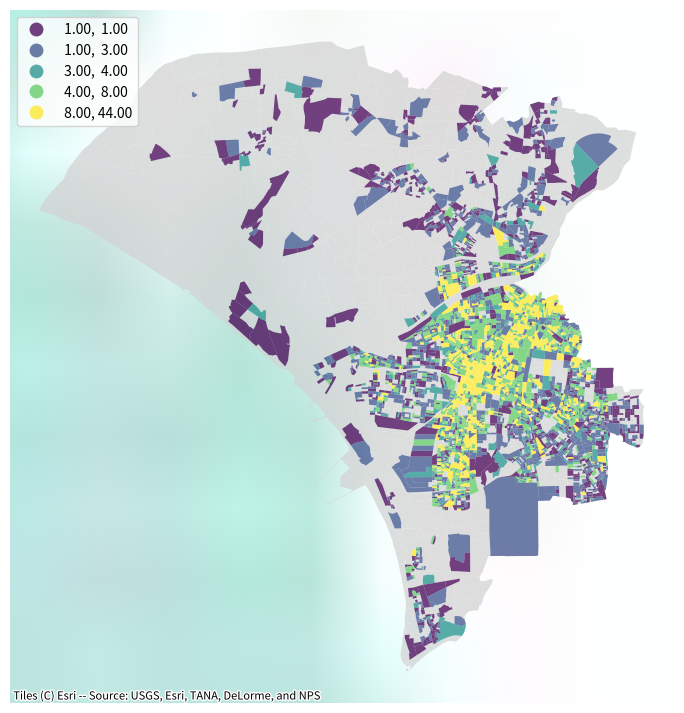

In [121]:
f, ax = plt.subplots(1, figsize=(9, 9))

# ✅ 先繪製 count 為 0 的區塊，顏色固定為灰色
db[db["count"] == 0].plot(
    color="lightgray",  # 固定灰色
    edgecolor="white",  # 邊界顏色
    linewidth=0.0,      # 無邊界線
    alpha=0.75,         # 半透明
    ax=ax               # 繪製在同一個 ax 上
)

# ✅ 再繪製 count > 0 的資料，使用分級色帶
db[db["count"] > 0].plot(
    column="count",                # 使用 count 欄位作為分級依據
    cmap="viridis",                # 色帶樣式
    scheme="quantiles",            # 使用分位數分級
    k=5,                           # 分成 5 等級
    edgecolor="white",             # 邊界顏色
    linewidth=0.0,                 # 無邊界線
    alpha=0.75,                    # 半透明
    legend=True,                   # 顯示圖例
    legend_kwds={"loc": 2},        # 圖例位置：左上角
    ax=ax                          # 繪製在同一個 ax 上
)


# ✅ 加入底圖（需要已投影為 Web Mercator）
contextily.add_basemap(
    ax,
    crs=db.crs,  # 使用原始資料的座標系統
    source=contextily.providers.Esri.WorldTerrain,  # 底圖來源
    zoom=6       # 底圖縮放層級
)

# ✅ 移除軸線
ax.set_axis_off()

In [122]:
# # ✅ 繪圖
# fig, ax = plt.subplots(figsize=(10, 10))
# db.plot(
#     column="count",
#     cmap="OrRd",
#     legend=True,
#     linewidth=0.1,
#     edgecolor="gray",
#     ax=ax
# )
# ax.set_xlim(db.total_bounds[0], db.total_bounds[2])
# ax.set_ylim(db.total_bounds[1], db.total_bounds[3])
# contextily.add_basemap(ax, crs=db.crs, zoom=12)
# ax.set_axis_off()
# ax.set_title("臺南最小統計區病例分布（count）", fontsize=16)
# plt.tight_layout()
# plt.show()

# Global spatial autocorrelation

In [123]:
# @title 使用8個最近鄰居

# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8) # 使用8個最近鄰居
# Row-standardization
w.transform = "R" # ✅ 將空間權重矩陣 w 標準化為「行標準化（Row-standardized）」

## Spatial lag

In [124]:
db["count_lag"] = weights.spatial_lag.lag_spatial(
    w, db["count"]
)

In [125]:
db.loc[["A6737-0210-00", "A6733-0731-00"], ["count", "count_lag"]]

,count,count_lag
CODEBASE,,
A6737-0210-00,44.0,14.00
A6733-0731-00,11.0,3.25


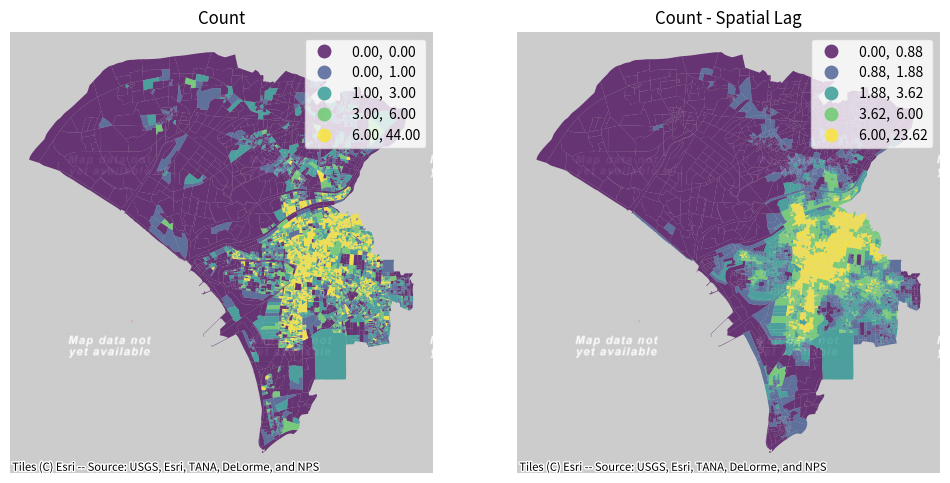

In [126]:
#@title draw spatial lag

f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(
    column="count",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("Count")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="count_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("Count - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

plt.show()

## Binary case: join counts

In [127]:
db["count_binary"] = (db["count"] > 3).astype(int)
db[["count", "count_binary"]].tail()

,count,count_binary
CODEBASE,,
A6735-0775-00,1.0,0
A6735-0759-00,0.0,0
A6735-0769-00,0.0,0
A6735-0771-00,0.0,0
A6735-0854-00,0.0,0


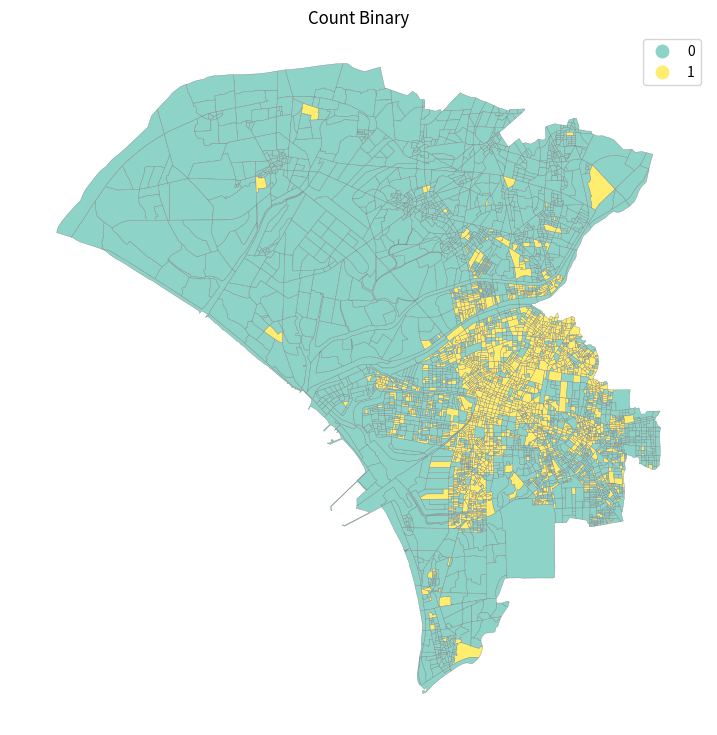

In [128]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(
    ax=ax,
    column="count_binary",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap="Set3",
    figsize=(9, 9),
)
ax.set_axis_off()
ax.set_title("Count Binary")
plt.axis("equal")
plt.show()

In [129]:
w.transform

'R'

In [130]:
w.transform = "O" # 這是設定 PySAL 的空間權重矩陣 w 的權重轉換方式為 "O"，也就是：✅ 不做任何標準化處理，保留原始的權重值。

In [131]:
w.transform

'O'

In [132]:
seed(1234)
jc = esda.join_counts.Join_Counts(db["count_binary"], w)


In [133]:
jc.bb # GG

np.float64(4725.0)

In [134]:
jc.ww # YY

np.float64(10350.5)

In [135]:
jc.bw # GY

np.float64(5508.5)

In [136]:
jc.bb + jc.ww + jc.bw

np.float64(20584.0)

In [137]:
jc.mean_bb # GG

np.float64(2683.053053053053)

In [138]:
jc.mean_bw # GY

np.float64(9496.964464464465)

In [139]:
jc.p_sim_bb

np.float64(0.001)

In [140]:
jc.p_sim_bw

np.float64(1.0)

# Continuous case: Moran Plot and Moran’s I

In [141]:
db["count_std"] = db["count"] - db["count"].mean() # 標準差
db["count_lag_std"] = weights.lag_spatial(
    w, db["count_std"]
)

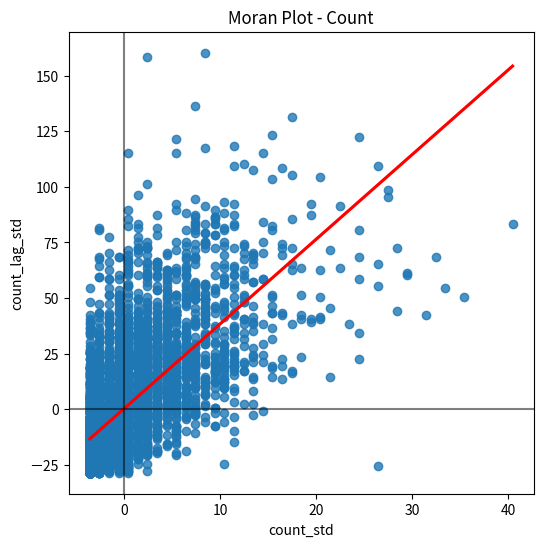

In [142]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="count_std",
    y="count_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Count")
plt.show()

In [143]:
w.transform = "R" # ✅ 將空間權重矩陣 w 標準化為「行標準化（Row-standardized）」
moran = esda.moran.Moran(db["count"], w)

In [144]:
moran.I

np.float64(0.47650921385047795)

In [145]:
moran.p_sim # ✅ 結果具有統計顯著性（空間自相關成立）

np.float64(0.001)

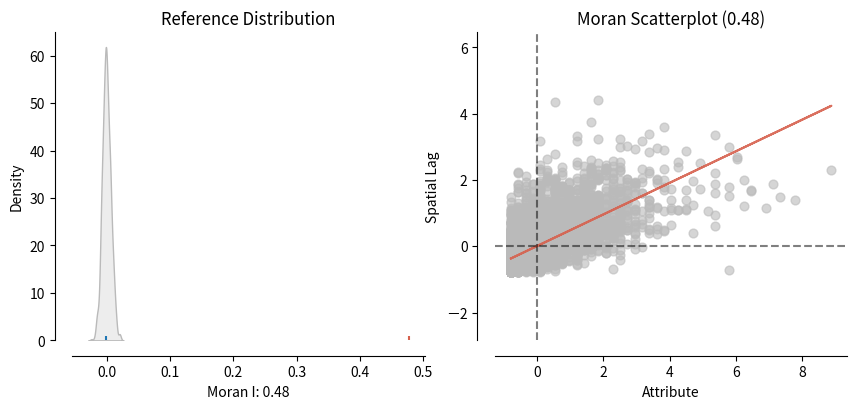

In [146]:
plot_moran(moran);

# Other global indices

## Geary’s C

In [147]:
geary = esda.geary.Geary(db["count"], w)

In [148]:
geary.C # 正向空間自相關（鄰近值相似）

np.float64(0.5160330680243552)

In [149]:
geary.p_sim

np.float64(0.001)

## Getis and Ord’s G

In [150]:
# 某個地點周圍是否形成高值或低值的集群。
db_osgb = db.to_crs(epsg=3826) # epsg=3826 TWD97 / epsg=27700 British National Grid
pts = db_osgb.centroid
xys = pandas.DataFrame({"X": pts.x, "Y": pts.y})
min_thr = weights.util.min_threshold_distance(xys)
min_thr # 找出「使得每個點至少有一個鄰居」所需的最小距離 d」

np.float64(1158.8580564338865)

In [151]:
w_db = weights.DistanceBand.from_dataframe(db_osgb, min_thr)

/usr/local/lib/python3.11/dist-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: A6735-0725-00.
  w = W(neighbors, weights, ids, **kwargs)
/usr/local/lib/python3.11/dist-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: A6735-0725-00.
  W.__init__(


In [152]:
gao = esda.getisord.G(db["count"], w_db)

In [153]:
print(
    "Getis & Ord G: %.3f | Pseudo P-value: %.3f" % (gao.G, gao.p_sim)
)

Getis & Ord G: 0.099 | Pseudo P-value: 0.001
